In [1]:
from pathlib import Path

# Get the current working directory as a Path object
current_path = Path.cwd()
home_folder = 'evan_home'

# Traverse up the directory tree until you find the target folder
for parent in [current_path] + list(current_path.parents):
    if parent.name == home_folder:
        home_path = parent
        break
else:
    raise ValueError(f"Folder '{home_folder}' not found in the current working directory.")

print("Home Path:", home_path)
source_code_dir = home_path / 'Source_code'
dataset_dir = home_path / 'Dataset'


Home Path: c:\Users\evanlee\Documents\Bmi_NAS_evan\evan_home


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import make_scorer, matthews_corrcoef
from sklearn.model_selection import cross_val_score, cross_validate, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler


In [3]:
import scanpy as sc

# adata = sc.read_h5ad(r"C:\Users\evanlee\Documents\Research_datasets\PBMC_Hao\GSE164378_Hao\Harmony_noZ\Hao_Harmony_test_no_scale.h5ad")
adata = sc.read_h5ad(dataset_dir / 'PBMC_Hao/GSE164378_Hao/Harmony_noZ/Hao_Harmony_test_no_scale.h5ad')
print('Original adata:', adata.shape)
adata.obs['celltype.l1'] = adata.obs['celltype.l1'].str.replace(' ', '_')
label = adata.obs['celltype.l1'].tolist()
types = np.unique(label).tolist()
print('all cell types:', types)
print('====================')
# del adata


Original adata: (161764, 33538)
all cell types: ['B', 'CD4_T', 'CD8_T', 'DC', 'Mono', 'NK', 'other', 'other_T']


# Z-transform adata

In [3]:
sc.pp.scale(adata, max_value=10)

## Read features

In [5]:
import os
# os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_batch_noZ\Level1\feature_selection_k3")
os.chdir(source_code_dir / 'PBMC_Hao_batch_noZ/Level1/feature_selection_k3')

features_dict = {}
# Read features for each celltype
for celltype in types:
    try:
        feature_df = pd.read_csv(f'{celltype}_features.txt', names=['Gene', 'Weight', 'Tendency'], sep='\t')
        features_dict[celltype] = feature_df
    except:
        print('skipping:', celltype)
        continue

In [6]:
count_df = pd.DataFrame(columns=['Feature_count', 'Positive_feature_count'])
for celltype in features_dict.keys():
    feature_df = features_dict[celltype]
    feature_count = feature_df.shape[0]
    positive_count = feature_df[feature_df['Tendency'] == 1].shape[0]
    count_df.loc[celltype] = [feature_count, positive_count]
count_df

,Feature_count,Positive_feature_count
B,19,10
CD4_T,201,95
CD8_T,23,9
DC,50,23
Mono,50,20
NK,33,17
other,5,3
other_T,247,112


## SVM (test)

In [6]:
celltype = 'B'
# subset data to celltype features
X = adata[:, features_dict[celltype]['Gene'].tolist()].X
# Binary label
y = [1 if i==celltype else 0 for i in adata.obs['celltype.l1'].tolist()]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

svm_clf = SVC(kernel='rbf', decision_function_shape='ovr', class_weight='balanced', max_iter=10000)
# OvR (one-vs-rest) decision function
# class_weight='balanced': Useful for imbalanced datasets, as it gives higher penalties to the minority class. Avoid bias toward the majority class
svm_clf.fit(X_train, y_train)

# Predictions on the test set
y_pred = svm_clf.predict(X_test)
# y_score = svm_clf.predict_proba(X_test)[:, 1]  # Probability estimates of the positive class

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
pr_auc = average_precision_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)

metrics = [accuracy, precision, recall, f1, roc_auc, pr_auc, mcc]
metrics

[0.9996909096528915,
 0.9967485549132948,
 0.9996376811594203,
 0.9981910274963821,
 0.9996667775918414,
 0.99641832316724,
 0.998023295629676]

## Stratified K-fold

In [7]:
import pickle

def SVM_strat_KFold(data, all_features_dict, celltype, k=5):
    # subset data to celltype features
    X = data[:, all_features_dict[celltype]['Gene'].tolist()].X
    # Binary label
    y = [1 if i==celltype else 0 for i in data.obs['celltype.l1'].tolist()]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

    print('Fitting SVM model...')
    svm_clf = SVC(kernel='rbf', decision_function_shape='ovr', class_weight='balanced', max_iter=10000)
    # OvR (one-vs-rest) decision function
    # class_weight='balanced': Useful for imbalanced datasets, as it gives higher penalties to the minority class. Avoid bias toward the majority class
    svm_clf.fit(X_train, y_train)

    scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score),
    'pr_auc': make_scorer(average_precision_score),
    'mcc': make_scorer(matthews_corrcoef)
    }

    print('Cross validation...')
    cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    cv_results = cross_validate(svm_clf, X_train, y_train, cv=cv, scoring=scoring, n_jobs=32)
    # return cv_results

    mean_accuracy = np.mean(cv_results['test_accuracy'])
    mean_precision = np.mean(cv_results['test_precision'])
    mean_recall = np.mean(cv_results['test_recall'])
    mean_f1 = np.mean(cv_results['test_f1'])
    mean_auc = np.mean(cv_results['test_roc_auc'])
    mean_pr_auc = np.mean(cv_results['test_pr_auc'])
    mean_mcc = np.mean(cv_results['test_mcc'])
    mean_metrics = [mean_accuracy, mean_precision, mean_recall, mean_f1, mean_auc, mean_pr_auc, mean_mcc]

    return svm_clf, mean_metrics




In [ ]:
# os.chdir(r'C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_batch_noZ\Level1\SVM_model')
os.chdir(source_code_dir / 'PBMC_Hao_batch_noZ/Level1/SVM_model')

cols = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']
all_metrics = pd.DataFrame(columns=cols)
# likelihood_dict = {}
for celltype in types:
    print('====================')
    print('K-fold CV for:', celltype)
    clf, metrics = SVM_strat_KFold(adata, features_dict, celltype, k=5)  # metrics is a list
    print(metrics)
    
    # Append metrics to all_metrics
    all_metrics.loc[celltype] = metrics

    # output SVM model as pickle
    filename = f'SVM_{celltype}_rbf_StardardScale_l1.pkl'
    with open(filename, 'wb') as f:
        pickle.dump(clf, f)

    # likelihood of the positive class for each observation
    # likelihood = clf.predict_proba(X)[:, 1]  # >0.5: predict celltype, <0.5: predict not celltype
    # print('likelihood > 0.5:', sum(likelihood > 0.5))  # decision_scores > 0 的有幾個
    # likelihood_dict[celltype] = likelihood


K-fold CV for: B
Fitting SVM model...
Cross validation...
[0.9997063617220292, 0.9975586447023266, 0.9990036231884059, 0.9982802351534998, 0.999387762961593, 0.9966494806370043, 0.9981202491983787]
K-fold CV for: CD4_T
Fitting SVM model...


c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Cross validation...
[0.9751721231450953, 0.9315411641471718, 0.9735983927569041, 0.9521039747145998, 0.9746524206823544, 0.9136379224984926, 0.9357747717594119]
K-fold CV for: CD8_T
Fitting SVM model...


c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Cross validation...
[0.9752803034530005, 0.8892724282873541, 0.9628957055214723, 0.9246198187698529, 0.9702451284912905, 0.8621239986211314, 0.9108940949828928]
K-fold CV for: DC
Fitting SVM model...
Cross validation...
[0.9977899886718958, 0.9207677357142247, 0.9853700954400848, 0.9519222633815021, 0.9917209257032887, 0.9076008885058335, 0.9513924302459061]
K-fold CV for: Mono
Fitting SVM model...
Cross validation...
[0.9943745099427007, 0.983174495194514, 0.9985207204617428, 0.9907881221291062, 0.9955465147906196, 0.9821683866371446, 0.9868007659545059]
K-fold CV for: NK
Fitting SVM model...
Cross validation...
[0.9919867763820406, 0.9435767292700554, 0.989753051344843, 0.9661076544599405, 0.9910155892643153, 0.9350894431902909, 0.9619234953757078]
K-fold CV for: other
Fitting SVM model...


c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Cross validation...
[0.42958682040985446, 0.03165736258945002, 0.32194159379640325, 0.03843830855911422, 0.3769376085338416, 0.02258731983476009, -0.07543474631818965]
K-fold CV for: other_T
Fitting SVM model...


c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Cross validation...
[0.9930840467564085, 0.920255353226495, 0.914565406334023, 0.9173508966147205, 0.9555445195890149, 0.8451871230558327, 0.9137744113181204]


In [9]:
all_metrics

,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC,MCC
B,0.999706,0.997559,0.999004,0.998280,0.999388,0.996649,0.998120
CD4_T,0.975172,0.931541,0.973598,0.952104,0.974652,0.913638,0.935775
CD8_T,0.975280,0.889272,0.962896,0.924620,0.970245,0.862124,0.910894
DC,0.997790,0.920768,0.985370,0.951922,0.991721,0.907601,0.951392
Mono,0.994375,0.983174,0.998521,0.990788,0.995547,0.982168,0.986801
NK,0.991987,0.943577,0.989753,0.966108,0.991016,0.935089,0.961923
other,0.429587,0.031657,0.321942,0.038438,0.376938,0.022587,-0.075435
other_T,0.993084,0.920255,0.914565,0.917351,0.955545,0.845187,0.913774


In [11]:
all_metrics.to_csv('SVM_metrics_rbf_StandardScale_l1.csv')

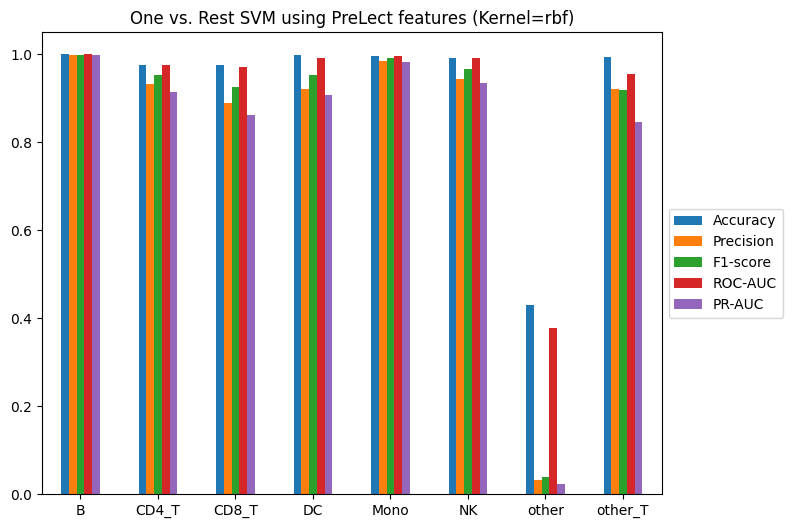

In [12]:
# Plot metrics for each celltype
cols = ['Accuracy', 'Precision', 'F1-score', 'ROC-AUC', 'PR-AUC']
ax = all_metrics[cols].plot.bar(rot=0, figsize=(8,6), title='One vs. Rest SVM using PreLect features (Kernel=rbf)')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

In [ ]:
# turn likelihood_dict into dataframe
# likelihood_df = pd.DataFrame(likelihood_dict)
# likelihood_df.head()

## Evaluate by DEGn

In [ ]:
count_df

In [8]:
# Read DEG table
# os.chdir("/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao_GSE/L1_by_lossdiff/L1_DEG/L1_DEG_table")
# os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_GSE\L1_by_lossdiff\L1_DEG\L1_DEG_table")
os.chdir(home_path / 'Source_code_supplementary/PBMC_Hao_GSE/L1_by_lossdiff/L1_DEG/L1_DEG_table')

# celltype = 'B'
DEG_table = pd.read_csv(celltype + '_DEG2000.csv', index_col=0)
# n_features = count_df.loc[celltype, 'Feature_count']  # 3902
# DEGn = DEG_table['names'][:n_features].tolist()

In [9]:
def SVM_classifier_DEG(data, DEGn, celltype):
    # subset data to celltype features
    X = data[:, DEGn].X
    # Binary label
    y = [1 if i==celltype else 0 for i in data.obs['celltype.l1'].tolist()]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

    svm_clf = SVC(kernel='linear', decision_function_shape='ovr', class_weight='balanced')
    svm_clf.fit(X_train, y_train)

    # Predictions on the test set
    y_pred = svm_clf.predict(X_test)
    # y_score = svm_clf.predict_proba(X_test)[:, 1]  # Probability estimates of the positive class

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    pr_auc = average_precision_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)

    metrics = [accuracy, precision, recall, f1, roc_auc, pr_auc, mcc]
    return svm_clf, metrics

In [ ]:
cols = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']
all_metrics_DEG = pd.DataFrame(columns=cols)

for celltype in types:
    print('==================')
    print('Constructing classifier for:', celltype)
    n_features = count_df.loc[celltype, 'Feature_count']
    print('n:', n_features)
    DEG_table = pd.read_csv(celltype + '_DEG2000.csv', index_col=0)
    DEGn = DEG_table['names'][:n_features].tolist() 
    clf, celltype_metrics = SVM_classifier_DEG(adata, DEGn, celltype)
    all_metrics_DEG.loc[celltype] = celltype_metrics